   

# 📈 2022 파이낸스 어낼리틱스 강민구/이윤지  

# 📈 소비자물가지수에 영향을 미치는 주요 경제 지표 분석 및 정책 제안 프로젝트


In [1]:
# 경로 지정(working directory)
setwd("C:/Users/mingu/Desktop/Finance Analytics Data")

***

## 💸 데이터 불러오기  


In [2]:
library(dplyr)

a <- read.csv("국제수지_20221103193403.csv", fileEncoding = 'euc-kr')
b <- read.csv("국제유가_도입현황_20221103191120.csv", fileEncoding = 'euc-kr')
c <- read.csv("소비자물가지수_2020100__20221103190937.csv", fileEncoding = 'euc-kr')
d <- read.csv("수출입총괄_20221103200616.csv", fileEncoding = 'euc-kr')
g <- read.csv("한국은행 기준금리.csv", fileEncoding = 'euc-kr')

# 데이터 확인

# 국제수지
#summary(a); head(a)

# 국제유가
#summary(b); head(b)

# 소비자 물가지수
#summary(c); head(c)
c <- c %>% rename("물가지수"="전국")

# 수출입총괄 : 무역수지
#summary(d); head(d); tail(d)
d <- d %>% rename("무역수지"="무역수지..천불.")

# 한국은행 기준금리
#summary(g); head(g)
g$변경월 <- substr(g$변경일자,1,2)
g$시점 <- paste(g$변경년도,".",g$변경월,sep="")
g1 <- g %>% filter(변경년도 < 2022 & 변경년도 > 2017)
#str(g1)
g2 <- g1 %>% select(시점,기준금리)

##### 민구 : 코스피, 환율, 유가, COFIX 금리, 코로나 확진자 수
##### 윤지 : 경상수지, 상품수지, 무역수지, 물가지수, 금리

# 데이터 전처리

data <- a %>% filter(as.numeric(substr(시점, 1,4))<2022) %>% select(시점, 경상수지, 상품수지) 
data1 <- d %>% filter(as.numeric(substr(시점, 1,4))<2022) %>% select(시점, 무역수지) 
data2 <- c %>% filter(as.numeric(substr(시점,1,4))<2022) %>% select(시점, 물가지수)

data$시점 <- as.character(data$시점)
data1$시점 <- as.character(data1$시점)
data2$시점 <- as.character(data2$시점)

for(i in 1:length(data$시점)){
  if(nchar(data$시점[i])==6){
    data$시점[i] <- paste(data$시점[i],"0",sep="")
  }
}

for(i in 1:length(data1$시점)){
  if(nchar(data1$시점[i])==6){
    data1$시점[i] <- paste(data1$시점[i],"0",sep="")
  }
}

for(i in 1:length(data2$시점)){
  if(nchar(data2$시점[i])==6){
    data2$시점[i] <- paste(data2$시점[i],"0",sep="")
  }
}

data <- left_join(data,g2,by='시점')
data <- left_join(data,data1,by='시점')
data <- left_join(data,data2,by='시점')

for(i in 1:length(data$시점)){
  if(is.na(data$기준금리[i])){
    if(i<11){data$기준금리[i] <- data$기준금리[11]}
    else if(i<19){data$기준금리[i] <- data$기준금리[19]}
    else if(i<22){data$기준금리[i] <- data$기준금리[22]}
    else if(i<27){data$기준금리[i] <- data$기준금리[27]}
    else if(i<29){data$기준금리[i] <- data$기준금리[29]}
    else if(i<44){data$기준금리[i] <- data$기준금리[44]}
    else if(i<47){data$기준금리[i] <- data$기준금리[47]}
    else{data$기준금리[i] <- 1.25}
  }
}


data_m <- read.csv("data_m.csv",header=T, fileEncoding="UTF-8-BOM")
#summary(data_m)
#colnames(data_m)
data_m <- data_m %>% rename("시점"="날짜") %>% rename("유가"="도입단가..US..배럴.") %>% rename("COFIX금리"="신규취급액기준.COFIX")
data_m$시점 <- as.character(data_m$시점)
for(i in 1:length(data_m$시점)){
  if(nchar(data_m$시점[i])==6){
    data_m$시점[i] <- paste(data_m$시점[i],"0",sep="")
  }
}

data <- full_join(data,data_m,by="시점")
data <- data %>% rename("환율"="종가")
head(data)
summary(data)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



시점,경상수지,상품수지,기준금리,무역수지,물가지수,환율,유가,KOSPI,COFIX금리,COVID
2018.01,2556.9,7338.0,1.75,3415969,98.106,1069.08,64.7,2520.938,1.78,0
2018.02,3226.7,4793.3,1.75,2801376,98.855,1084.21,67.8,2439.104,1.77,0
2018.03,5210.4,9216.5,1.75,6412094,98.751,1060.25,64.4,2451.570,1.82,0
2018.04,1490.4,9402.2,1.75,6156273,98.931,1069.33,65.9,2458.225,1.79,0
2018.05,8792.3,10550.2,1.75,6229021,98.979,1079.59,70.3,2461.301,1.82,0
2018.06,7980.1,9413.5,1.75,6079212,98.779,1113.91,74.6,2394.508,1.84,0


     시점              경상수지        상품수지          기준금리    
 Length:48          Min.   :-4024   Min.   :  488.2   Min.   :0.500  
 Class :character   1st Qu.: 4845   1st Qu.: 5687.7   1st Qu.:0.750  
 Mode  :character   Median : 6801   Median : 6861.2   Median :1.000  
                    Mean   : 6278   Mean   : 7223.1   Mean   :1.151  
                    3rd Qu.: 8188   3rd Qu.: 9262.9   3rd Qu.:1.500  
                    Max.   :12063   Max.   :13105.2   Max.   :1.750  
    무역수지           물가지수           환율           유가      
 Min.   :-1662429   Min.   : 98.11   Min.   :1060   Min.   :24.10  
 1st Qu.: 2247774   1st Qu.: 99.33   1st Qu.:1114   1st Qu.:59.92  
 Median : 3818792   Median : 99.76   Median :1146   Median :65.85  
 Mean   : 3806648   Mean   :100.26   Mean   :1147   Mean   :63.14  
 3rd Qu.: 5745334   3rd Qu.:100.81   3rd Qu.:1187   3rd Qu.:73.30  
 Max.   : 9617280   Max.   :104.04   Max.   :1231   Max.   :82.40  
     KOSPI        COFIX금리         COVID         
 Min.   :17

***

## 💸 8가지 가정 검정  


corrplot 0.92 loaded


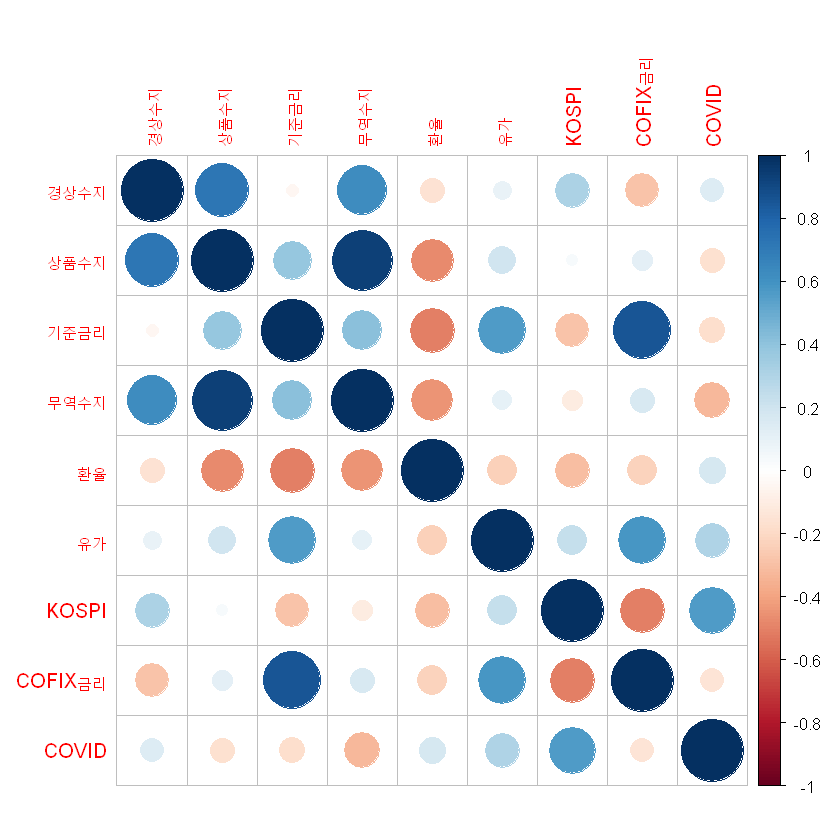

In [3]:
# 독립변수 간 상관계수 계산(가정6 확인)
data_cor <- data %>% select(-c("시점","물가지수"))
data_cor <- cor(data_cor)
#install.packages("corrplot")
library(corrplot)
corrplot(data_cor)  

  
<br>  

강한 양의 상관관계는 무역수지-상품수지, 경상수지-상품수지, 경상수지-무역수지, COFIX금리-기준금리에서 보였으며, 강한 음의 상관관계는 없었습니다.  

다중공산성을 제거하기 위해 무역수지, 상품수지, 경상수지 중 하나만 사용하기로 결정하며, 상품수지만을 남기기로 하였습니다.  
또한 COFIX금리와 기준금리 중 기준금리를 이용하기로 하였습니다.  
<br>


In [4]:
data <- data %>% select(-c("무역수지","경상수지","COFIX금리"))  

***

<br>
📌 1) 가정1 : 변수 Y와 X의 관계는 선형(Linear)이다.  
  - 잔차, scatter plot으로 확인 가능(모형 설정 후 확인)  
  
📌 2) 가정2 : X는 확률변수가 아닌 주어진 상수값이다.  
  - 그냥 받아들인다.  
  
📌 3) 가정3 : X값이 주어져 있을 때, 오차항의 평균은 0이다.  
  - 잔차 plot으로 확인(모형 설정 후 확인)  
  
📌 4) 가정4 : X값이 주어져 있을때, 오차항의 분산은 시그마^2 로 모든 개체 i에 대해 동일하다.  
  - 잔차 plot으로 확인, 로그변환으로 해결(모형 설정 후 확인)  
  
📌 5) 가정5 : 서로 다른 개체간 오차항들은 상관되어있지 않다.  
  - 오차항의 자기상관 문제(모형 설정 후 확인)  
  - 잔차의 time plot / 잔차의 autocorrelation function / 더빗왓슨 검정 으로 확인  
  - 시게열 가변수 추가 / 과거 독립변수값을 새로운 독립변수로 추가 / 변수변환 - 차분  
  
📌 6) 가정6 : X변수들이 여러 개 있을 때, X변수들 사이에는 선형관계가 없다  
  - 다중공선성 문제가 없음을 가정  
  - 높은 독립변수 간 상관계수 / 높은 R-square값, 그러나 유의하지 않은 t값  
  - 상관계수가 높은 독립변수 제거  
  
📌 7) 가정7 : 모형 설정 오류가 없음  
  - 그냥 받아들인다.  
  
📌 8) 가정8 : 오차항은 정규분포를 따름을 가정(모형 설정 후 확인)  
  - 잔차의 Histogram과 Normal qq plot이 Plot1과 같음을 확인  
  
📌 가정 1,3,4,5,8는 모형 설정 후 진단한다.  
<br>  

***  

## 💸 시계열 데이터로 만들기  


In [5]:
#################
## 변수명 변경 ##
#################
data$interest <- data$기준금리
data$lngoods <- log(data$상품수지)
data$priceindex <- data$물가지수
data$lnexchange <- log(data$환율)
data$lnoil <- log(data$유가)
data$lnKOSPI <- log(data$KOSPI)
str(data)
## 종속변수인 물가지수는 비율(%)이므로 로그변환을 하지 않는다.
## 로그변환이 가능한 독립변수는 로그변환 시킨다.
## 비율 기준 금리는 제외하고 진행한다.
## COVID는 0을 포함하기 때문에 로그변환을 하지 않는다.

'data.frame':	48 obs. of  14 variables:
 $ 시점      : chr  "2018.01" "2018.02" "2018.03" "2018.04" ...
 $ 상품수지  : num  7338 4793 9216 9402 10550 ...
 $ 기준금리  : num  1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 ...
 $ 물가지수  : num  98.1 98.9 98.8 98.9 99 ...
 $ 환율      : num  1069 1084 1060 1069 1080 ...
 $ 유가      : num  64.7 67.8 64.4 65.9 70.3 74.6 75.2 77.4 77 80 ...
 $ KOSPI     : num  2521 2439 2452 2458 2461 ...
 $ COVID     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ interest  : num  1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 ...
 $ lngoods   : num  8.9 8.47 9.13 9.15 9.26 ...
 $ priceindex: num  98.1 98.9 98.8 98.9 99 ...
 $ lnexchange: num  6.97 6.99 6.97 6.97 6.98 ...
 $ lnoil     : num  4.17 4.22 4.17 4.19 4.25 ...
 $ lnKOSPI   : num  7.83 7.8 7.8 7.81 7.81 ...


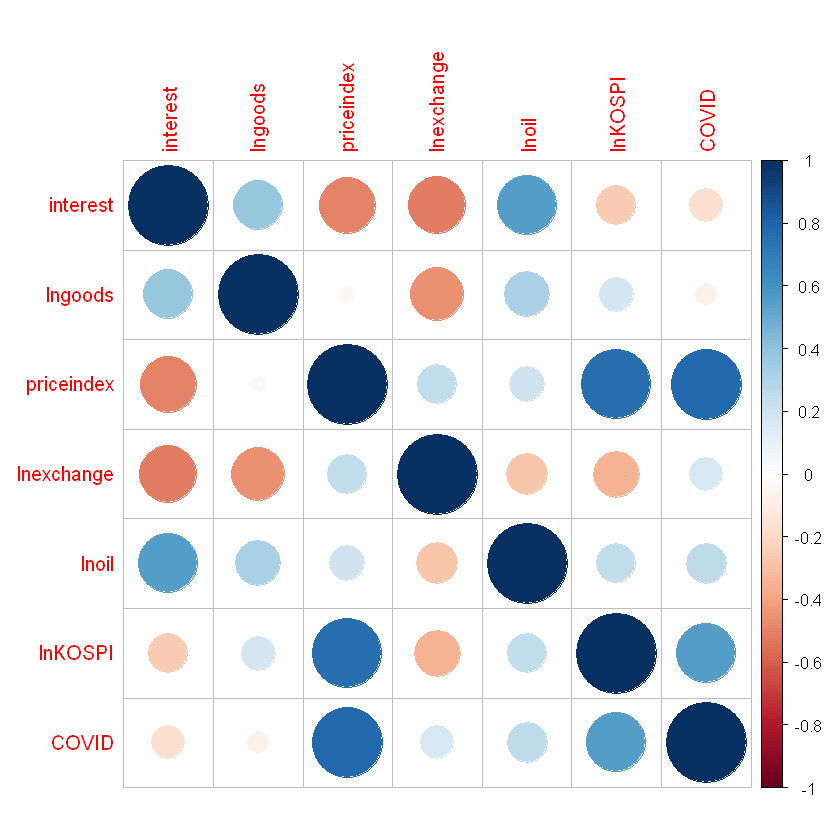

In [6]:
# 로그 변환 후 상관계수 확인
data_cor <- data %>% select(c("interest","lngoods","priceindex","lnexchange","lnoil","lnKOSPI","COVID"))
data_cor <- cor(data_cor)
corrplot(data_cor)  

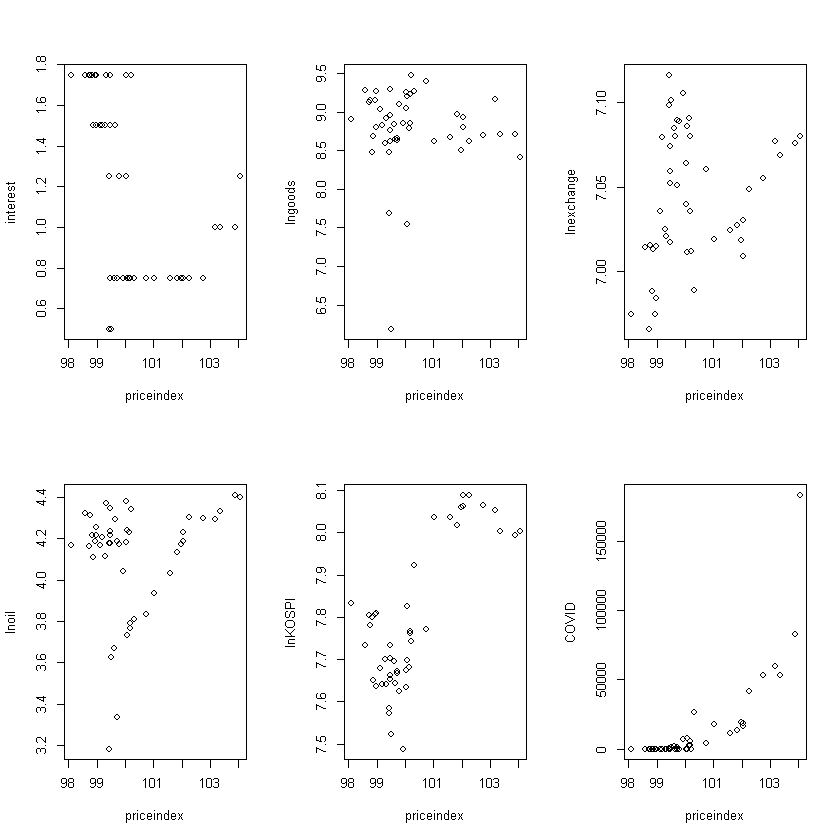

In [7]:
# 종속변수와 각 독립변수의 그래프 확인
data_ts <- ts(data, frequency = 12, start=c(2018,1))
par(mfrow=c(2,3))
plot(interest~priceindex, data=data_ts)
plot(lngoods~priceindex, data=data_ts)
plot(lnexchange~priceindex, data=data_ts)
plot(lnoil~priceindex, data=data_ts)
plot(lnKOSPI~priceindex, data=data_ts)
plot(COVID~priceindex,data=data_ts)
par(mfrow=c(1,1))  

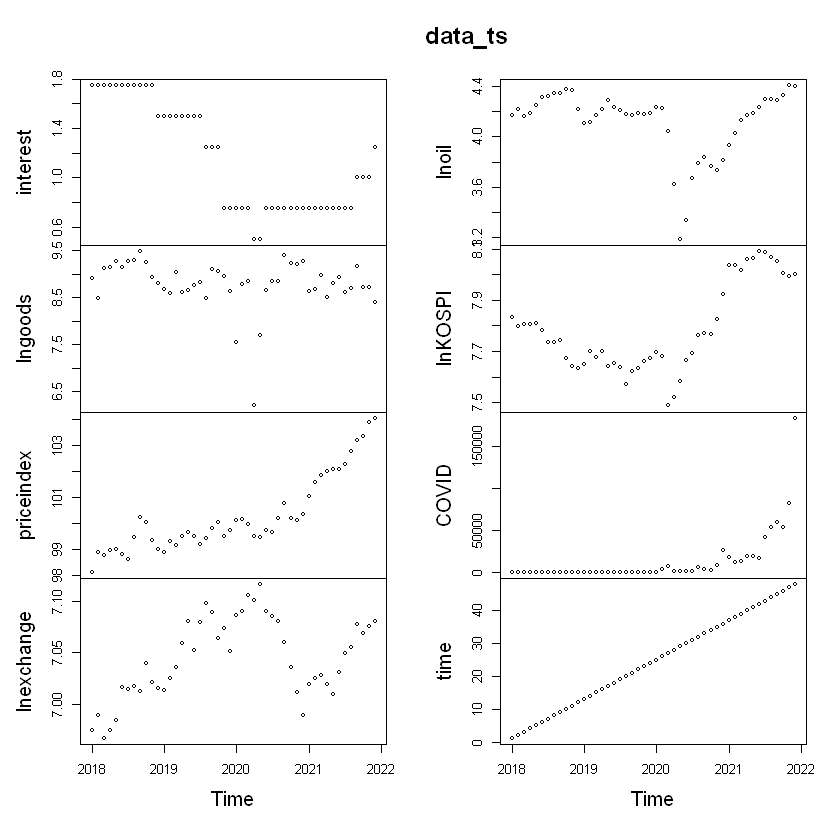

In [8]:
data$time <- c(1:48) # time 변수 만들기 #
data <- data %>% select(c("interest","lngoods","priceindex","lnexchange","lnoil","lnKOSPI","COVID","time"))
data_ts <- ts(data, frequency = 12, start=c(2018,1))
plot(data_ts,type="p")
# 분산이 점차 커지는 변수가 많으므로, 로그 변환하기로 결정을 내렸다.

***

## 💸 기본 다중회귀 모형 테스트  


In [9]:
model1 <- lm(priceindex~interest+lngoods+lnexchange+lnoil+lnKOSPI+COVID, data=data_ts)
summary(model1)
## lngoods의 p-value가 유의하지 않으므로 제거한다.  


Call:
lm(formula = priceindex ~ interest + lngoods + lnexchange + lnoil + 
    lnKOSPI + COVID, data = data_ts)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.87271 -0.25338 -0.00091  0.23791  0.91024 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.681e+01  2.565e+01  -1.435  0.15877    
interest    -8.041e-01  2.939e-01  -2.735  0.00916 ** 
lngoods      1.800e-01  1.384e-01   1.300  0.20079    
lnexchange   1.318e+01  2.997e+00   4.398 7.58e-05 ***
lnoil        1.023e+00  3.508e-01   2.916  0.00572 ** 
lnKOSPI      5.029e+00  7.680e-01   6.548 7.19e-08 ***
COVID        1.477e-05  3.030e-06   4.874 1.68e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4295 on 41 degrees of freedom
Multiple R-squared:  0.9253,	Adjusted R-squared:  0.9143 
F-statistic: 84.62 on 6 and 41 DF,  p-value: < 2.2e-16


In [10]:
model2 <- lm(priceindex~interest+lnexchange+lnoil+lnKOSPI+COVID, data=data_ts)
summary(model2)
## 절편의 p-value가 유의하지 않으므로 제거한다.  


Call:
lm(formula = priceindex ~ interest + lnexchange + lnoil + lnKOSPI + 
    COVID, data = data_ts)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9346 -0.2470 -0.0066  0.2208  0.9752 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.470e+01  2.580e+01  -1.345 0.185913    
interest    -7.310e-01  2.909e-01  -2.513 0.015892 *  
lnexchange   1.288e+01  3.013e+00   4.276 0.000107 ***
lnoil        1.050e+00  3.530e-01   2.973 0.004864 ** 
lnKOSPI      5.208e+00  7.617e-01   6.838 2.48e-08 ***
COVID        1.419e-05  3.022e-06   4.696 2.84e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.433 on 42 degrees of freedom
Multiple R-squared:  0.9222,	Adjusted R-squared:  0.9129 
F-statistic: 99.57 on 5 and 42 DF,  p-value: < 2.2e-16


In [11]:
model3 <- lm(priceindex~interest+lnexchange+lnoil+lnKOSPI+COVID-1, data=data_ts)
summary(model3)
## 각 독립변수는 p-value가 유의하고 모형의 R-square는 100%의 설명력을 가진다.
## 모델에서 절편을 제거한 경우 모델은 한계점을 가졌다.  


Call:
lm(formula = priceindex ~ interest + lnexchange + lnoil + lnKOSPI + 
    COVID - 1, data = data_ts)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.97765 -0.27946  0.02837  0.22766  0.97894 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
interest   -1.018e+00  1.992e-01  -5.111 7.03e-06 ***
lnexchange  8.870e+00  4.206e-01  21.091  < 2e-16 ***
lnoil       1.204e+00  3.370e-01   3.573 0.000887 ***
lnKOSPI     4.339e+00  4.060e-01  10.687 1.11e-13 ***
COVID       1.667e-05  2.416e-06   6.901 1.79e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4371 on 43 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 5.052e+05 on 5 and 43 DF,  p-value: < 2.2e-16



## 💸 잔차 검정(가정 3,4,5,6,8을 진단한다.)  


📌 시계열 회귀분석에서는 아래 상황을 고려한다.  

  - 가정 5번째를 반드시 체크를 해야한다.   
  - 서로 다른 개체간 오차항들은 상관되어 있지 않다. = 자기 상관(autocorrelation)  
  - 오차항의 자기상관 문제는 시계열 자료에서 발생한다.  
  - 자기상관이 없을 순 없다. 그럼에도 회귀분석을 한다. 이는 x변수 자체도 시계열 변수이기 때문이다.  
  - x,y가 상관되어 있지 않다가 아닌 "오차항"이 상관되어 있지 않다는 의미이다.  
  - x자기상관, y자기상관은 상관없다. 잔차에 자기상관이 남아있으면 조치를 취해야 함.  

  - y_hat residual에서 분산이 커지면 log를 취한다.  
  
<br>  


📌 오차에 자기상관이 남아있을 수 있다. 확인하는 세 가지 방법은 다음과 같다.  
  - 1) 잔차의 time plot : x축 yhat ,y축 residual로는 못 본다. x축이 time이여야 볼 수 있다.  
  - 2) 잔차의 autocorrealtion function  
  - 3) 더빈왓슨 검정


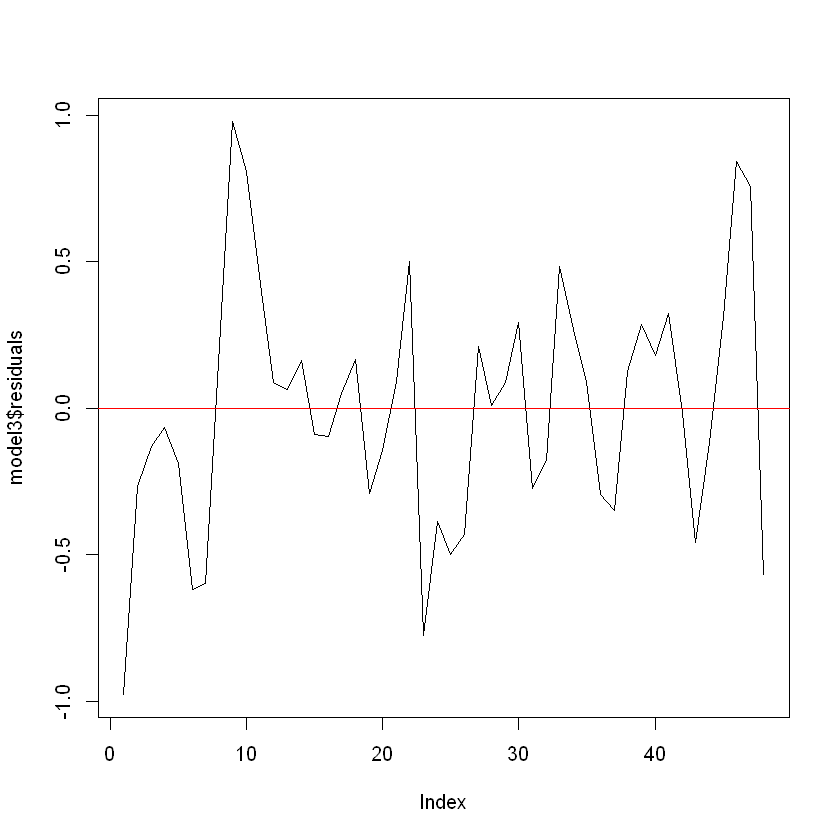

In [12]:
## 1) 잔차의 time plot
# 원래 잔차는 연결하면 안 된다. 원래 잔차는 행의 위치가 바껴도 상관이 없다.
# 그러나 time data는 행 순서가 바뀔 수 없다. 시간에 흐름에 따라 순서도 자료이다.
par(mfrow=c(1,1))
plot(model3$residuals, type="l") # both : type='b', line : type='l'
abline(h=0, col="red")

# 자기상관이 없으면 랜덤하게 있어야 한다.
# 자기 상관이 있으면 - -> -, + -> + 내려와있다가 올라와있다.
# 자기 상관이 없다고 판단된다.  

Warning message:
"package 'lmtest' was built under R version 3.6.3"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




	Durbin-Watson test

data:  model3
DW = 1.1016, p-value = 4.423e-05
alternative hypothesis: true autocorrelation is greater than 0


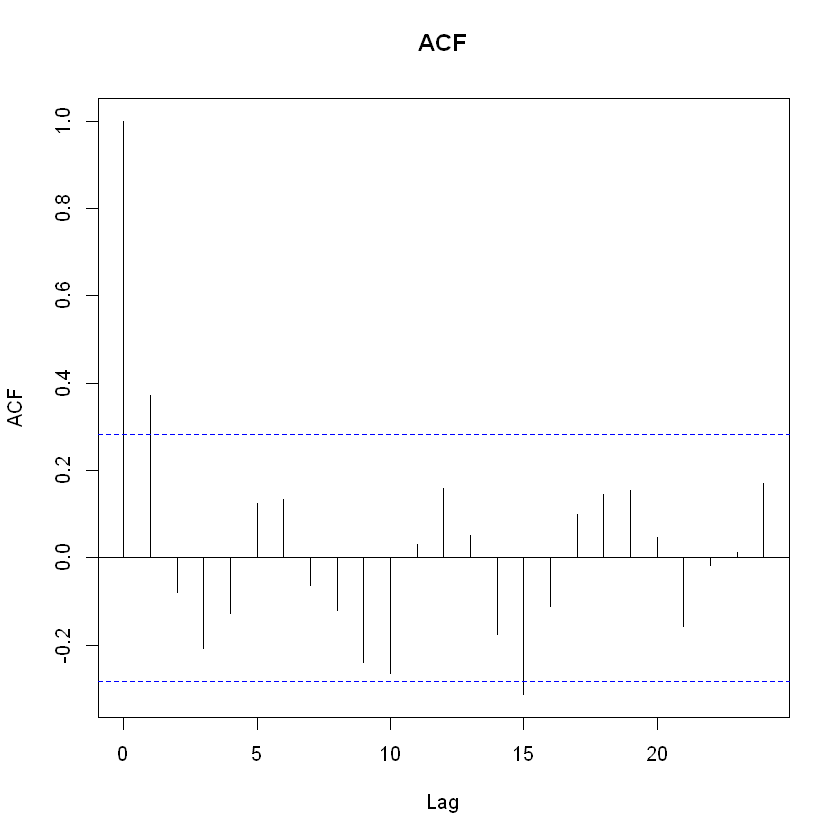

In [13]:
## 2) 잔차의 자기상관도표(ACF) : 잔차의 자기상관계수 계산
## 특별한 패키지가 필요하지 않다.
acf(model3$residuals, main="ACF", lag.max=24)
## 1차 상관계수, 2차 상관계수
# 파란색 안으로 들어와 있다 = 자기상관 없다. 
# monthly 데이터에서 1년 전 데이터, 계절성이 있을 수 있다. 적어도 24까지는 봐야한다.
# 옵션으로 계절성 확인하자.
### but 1차 자기상관계수, 15차 자기상관계수가 유의미한게 있다.

## 3) 더빈왓슨 검정
## 1차 자기상관이 0이면 2에 가까운 값을 갖는다.
## 1차 자기상관이 positive correlation 이면 0이고,
## 1차 자기상관이 negative correlation 이면 4이다.
## 2에 가까울수록 문제가 없는 것이다.

## DW test ##
#install.packages("lmtest")
library(lmtest)
dwtest(model3)

## 귀무가설 : 자기상관이 없다. d=2
## p-value 작다. H0 기각, 자기상관이 있다.
## 내가 바라는 건 p-value > 0.05이기 바란다.

## 결과 값을 보면 4.423e-05로 <0.05, 자기상관이 있다.
## DW만 보면 안되는 이유는 1차 자기상관만 확인가능하기 때문이다.
## something special : 계절성 확인 어렵다.
## 그래서 ACF까지도 같이 확인해야 한다.
## ACF는 다 보여주는 것

***

## 💸 오차의 자기상관 해결방법  

📌 1) 독립변수 추가 : 시계열 가변수 추가  

  - 자기상관이 생기는 이유 : 추세, 계절성, 순환(cycle)  
  - 1) 추세 : 증가하는 추세, 독립변수에 추세(t, t^2)를 넣어줌으로 해결(가짜변수) 한 달 지날때마다 저만큼 증가합니다.  
  - 2) 계절을 반영하는 가변수(dummy variable)을 모형에 독립변수로 추가한다.  
    - x: time, y:y변수 plot을 통해 계절성을 확인하자. dummy 12개 넣고 유의미하지 않은 dummy는 지운다.  
    - 가짜변수를 많이 넣어 R square의 설명력을 높이면 prediction 예측할 때 유리  
  - 3) 순환효과를 설명하는 삼각함수항을 추가한다.  
    - 사인과 코사인을 같이 넣어서 주기를 맞춘다. 고정폭, 확산폭  
    


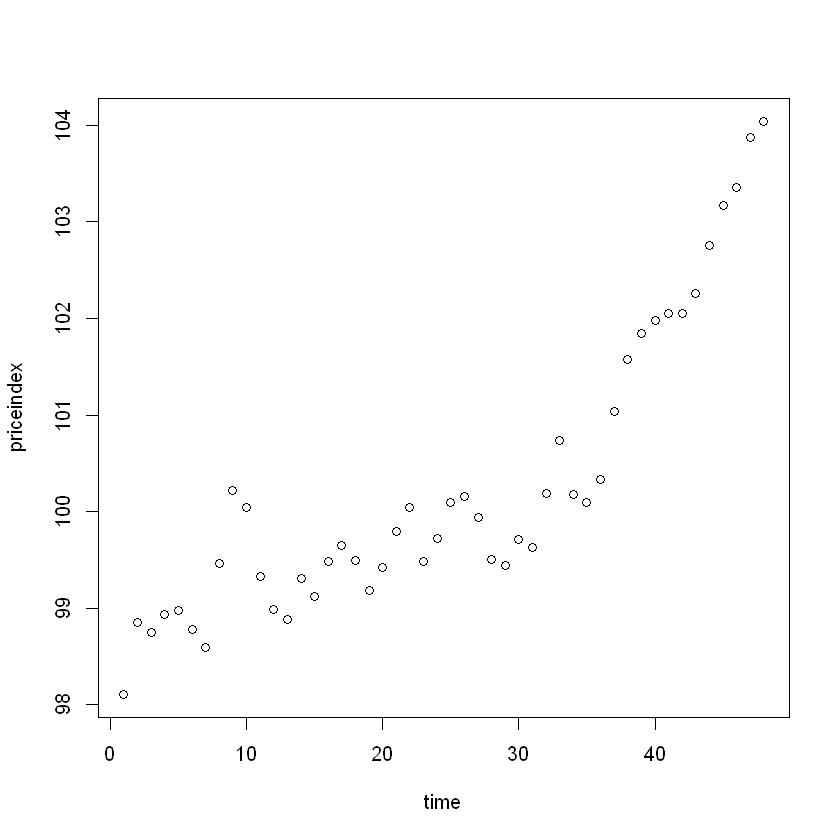

In [14]:
plot(priceindex ~ time, data=data_ts)
# 시간에 따라 증가하는 추세가 있어보인다.

In [15]:
# time 변수 추가
model3 <- lm(priceindex~interest+lnexchange+lnoil+lnKOSPI+COVID-1, data=data_ts)

modelwithtrend1 <- lm(priceindex~interest+lnexchange+lnoil+lnKOSPI+COVID+time-1, data=data_ts)
summary(modelwithtrend1)  


Call:
lm(formula = priceindex ~ interest + lnexchange + lnoil + lnKOSPI + 
    COVID + time - 1, data = data_ts)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.76433 -0.23957  0.03931  0.21630  0.93324 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
interest   6.480e-01  3.417e-01   1.896   0.0648 .  
lnexchange 9.488e+00  3.444e-01  27.546  < 2e-16 ***
lnoil      9.051e-01  2.664e-01   3.398   0.0015 ** 
lnKOSPI    3.498e+00  3.497e-01  10.001 1.12e-12 ***
COVID      5.658e-06  2.749e-06   2.059   0.0458 *  
time       6.733e-02  1.232e-02   5.464 2.33e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3381 on 42 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 7.036e+05 on 6 and 42 DF,  p-value: < 2.2e-16


In [16]:
modelwithtrend2 <- lm(priceindex~lnexchange+lnoil+lnKOSPI+COVID+time-1, data=data_ts)
summary(modelwithtrend2)


Call:
lm(formula = priceindex ~ lnexchange + lnoil + lnKOSPI + COVID + 
    time - 1, data = data_ts)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.60212 -0.23322  0.05505  0.20634  0.98336 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
lnexchange 9.306e+00  3.406e-01  27.323  < 2e-16 ***
lnoil      1.149e+00  2.401e-01   4.785 2.04e-05 ***
lnKOSPI    3.690e+00  3.447e-01  10.707 1.04e-13 ***
COVID      8.619e-06  2.329e-06   3.701 0.000607 ***
time       4.648e-02  5.724e-03   8.120 3.21e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3482 on 43 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 7.962e+05 on 5 and 43 DF,  p-value: < 2.2e-16



	Durbin-Watson test

data:  model2
DW = 1.1533, p-value = 7.109e-05
alternative hypothesis: true autocorrelation is greater than 0



	Durbin-Watson test

data:  modelwithtrend2
DW = 1.1701, p-value = 0.000138
alternative hypothesis: true autocorrelation is greater than 0


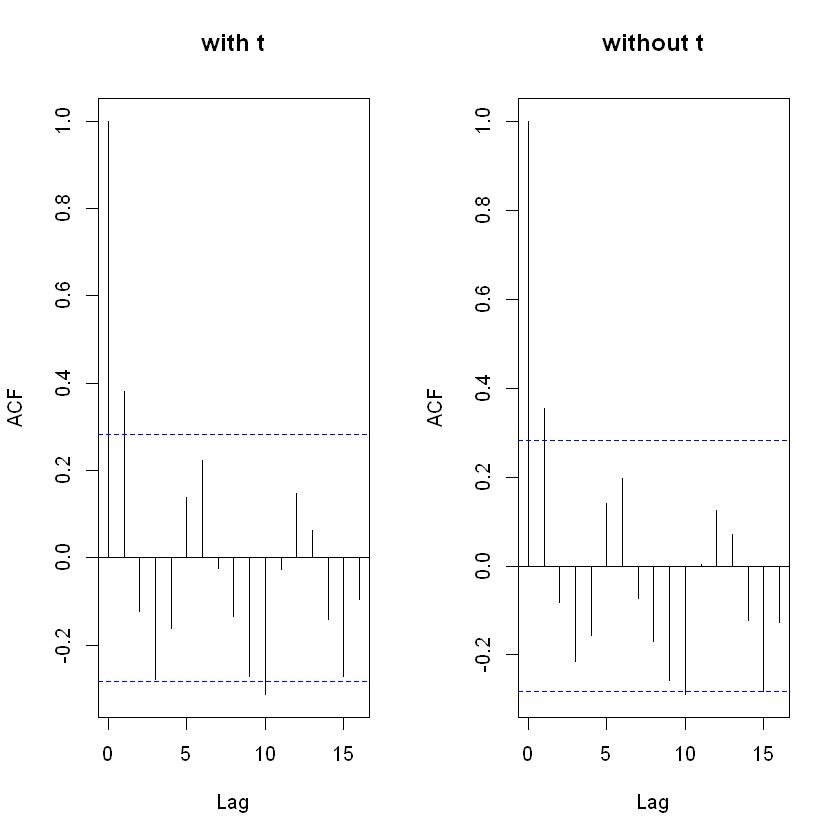

In [17]:
par(mfrow=c(1,2))
acf(modelwithtrend2$residuals,main="with t")
acf(model2$residuals, main="without t")

dwtest(model2) ; dwtest(modelwithtrend2)
## dwtest 결과 time변수를 추가하여도 여전히 낮은 p-value를 취한다.
## 따라서 time 변수는 추가하지 않는다.  

📌 2) 독립변수의 과거값을 새로운 독립변수로 추가  
  - 과거 x변수를 넣는다. 독립변수에 작년 것을 넣는다 => 시계열모형으로 간다.(선형회귀 area 밖)  
  - 선형변수 가정 : x변수는 주어졌다고 생각하자를 위반  
  - OLS를 못 쓴다. -> 시계열 모형(AR)으로 넘어감, 형태는 똑같음  
  


In [18]:
## input X_t-1 ##
nn = dim(data_ts)[1]
data$interest1 <- c(NA, data$interest[1:nn-1])
data_ts <- ts(data, frequency = 12, start=c(2018,1))

model3 <- lm(priceindex~interest+lnexchange+lnoil+lnKOSPI+COVID-1, data=data_ts)
summary(model3)  


Call:
lm(formula = priceindex ~ interest + lnexchange + lnoil + lnKOSPI + 
    COVID - 1, data = data_ts)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.97765 -0.27946  0.02837  0.22766  0.97894 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
interest   -1.018e+00  1.992e-01  -5.111 7.03e-06 ***
lnexchange  8.870e+00  4.206e-01  21.091  < 2e-16 ***
lnoil       1.204e+00  3.370e-01   3.573 0.000887 ***
lnKOSPI     4.339e+00  4.060e-01  10.687 1.11e-13 ***
COVID       1.667e-05  2.416e-06   6.901 1.79e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4371 on 43 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 5.052e+05 on 5 and 43 DF,  p-value: < 2.2e-16


,interest,lngoods,priceindex,lnexchange,lnoil,lnKOSPI,COVID,time,interest1
interest,1.0000000,0.38969836,-0.49141293,-0.5102393,0.5544974,-0.2521452,-0.17484184,-0.8184683,NA
lngoods,0.3896984,1.00000000,-0.03943959,-0.4535605,0.3229071,0.1881598,-0.07245593,-0.1904409,NA
priceindex,-0.4914129,-0.03943959,1.00000000,0.2477552,0.2017965,0.7560660,0.78413359,0.8718920,NA
lnexchange,-0.5102393,-0.45356051,0.24775519,1.0000000,-0.2733702,-0.3418975,0.17956309,0.4323926,NA
lnoil,0.5544974,0.32290706,0.20179654,-0.2733702,1.0000000,0.2468971,0.25470521,-0.2034728,NA
lnKOSPI,-0.2521452,0.18815981,0.75606600,-0.3418975,0.2468971,1.0000000,0.55578175,0.5972433,NA
COVID,-0.1748418,-0.07245593,0.78413359,0.1795631,0.2547052,0.5557818,1.00000000,0.6013824,NA
time,-0.8184683,-0.19044090,0.87189197,0.4323926,-0.2034728,0.5972433,0.60138236,1.0000000,NA
interest1,NA,NA,NA,NA,NA,NA,NA,NA,1


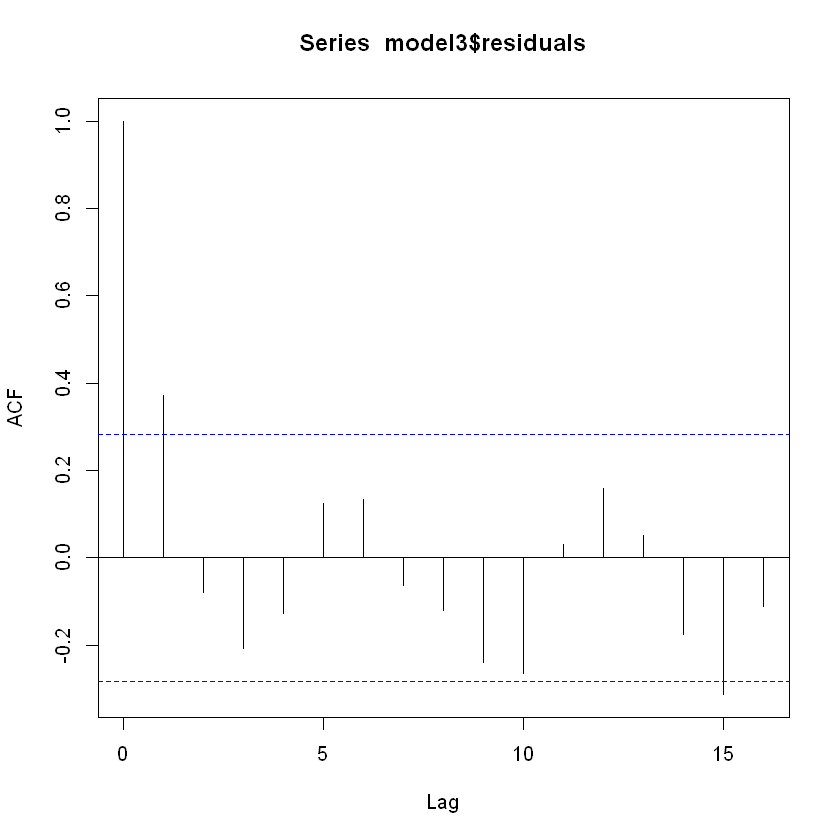

In [19]:
cor(data_ts)
acf(model3$residuals)
model3 <- lm(priceindex~interest+lnexchange+lnoil+lnKOSPI+COVID-1, data=data_ts)  


Call:
lm(formula = priceindex ~ interest + interest + lnexchange + 
    lnoil + lnKOSPI + COVID - 1, data = data_ts)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.97765 -0.27946  0.02837  0.22766  0.97894 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
interest   -1.018e+00  1.992e-01  -5.111 7.03e-06 ***
lnexchange  8.870e+00  4.206e-01  21.091  < 2e-16 ***
lnoil       1.204e+00  3.370e-01   3.573 0.000887 ***
lnKOSPI     4.339e+00  4.060e-01  10.687 1.11e-13 ***
COVID       1.667e-05  2.416e-06   6.901 1.79e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4371 on 43 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 5.052e+05 on 5 and 43 DF,  p-value: < 2.2e-16



	Durbin-Watson test

data:  modelwithinterest
DW = 1.1016, p-value = 4.423e-05
alternative hypothesis: true autocorrelation is greater than 0


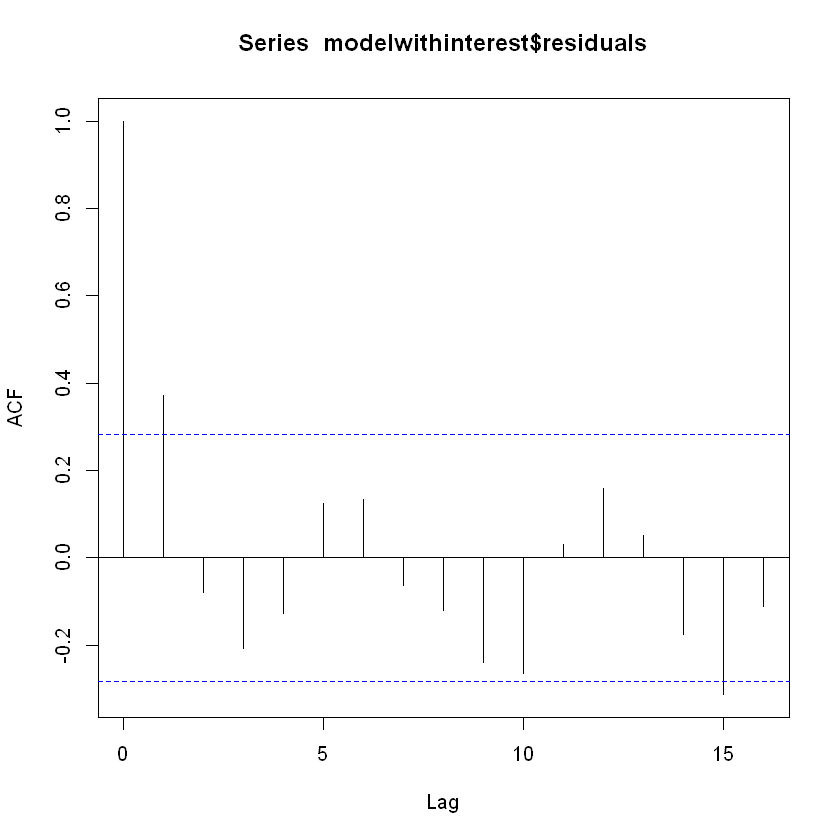

In [20]:
modelwithinterest<- lm(priceindex~interest+interest+lnexchange+lnoil+lnKOSPI+COVID-1, data=data_ts)
summary(modelwithinterest)
acf(modelwithinterest$residuals)
dwtest(modelwithinterest)
## 유의미하지 않은 변수 추가로 더 나빠짐. 해결 안 된다.  


Call:
lm(formula = priceindex ~ interest + lnexchange + lnoil + lnKOSPI + 
    COVID1 - 1, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.70333 -0.19866 -0.03687  0.19893  0.89431 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
interest   -6.709e-01  1.809e-01  -3.708  0.00062 ***
lnexchange  9.218e+00  3.818e-01  24.144  < 2e-16 ***
lnoil       9.282e-01  2.878e-01   3.225  0.00247 ** 
lnKOSPI     4.110e+00  3.652e-01  11.254 4.10e-14 ***
COVID1      4.050e-05  4.623e-06   8.761 6.13e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3643 on 41 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 6.983e+05 on 5 and 41 DF,  p-value: < 2.2e-16



	Durbin-Watson test

data:  modelwithCOVID1
DW = 1.3517, p-value = 0.001872
alternative hypothesis: true autocorrelation is greater than 0


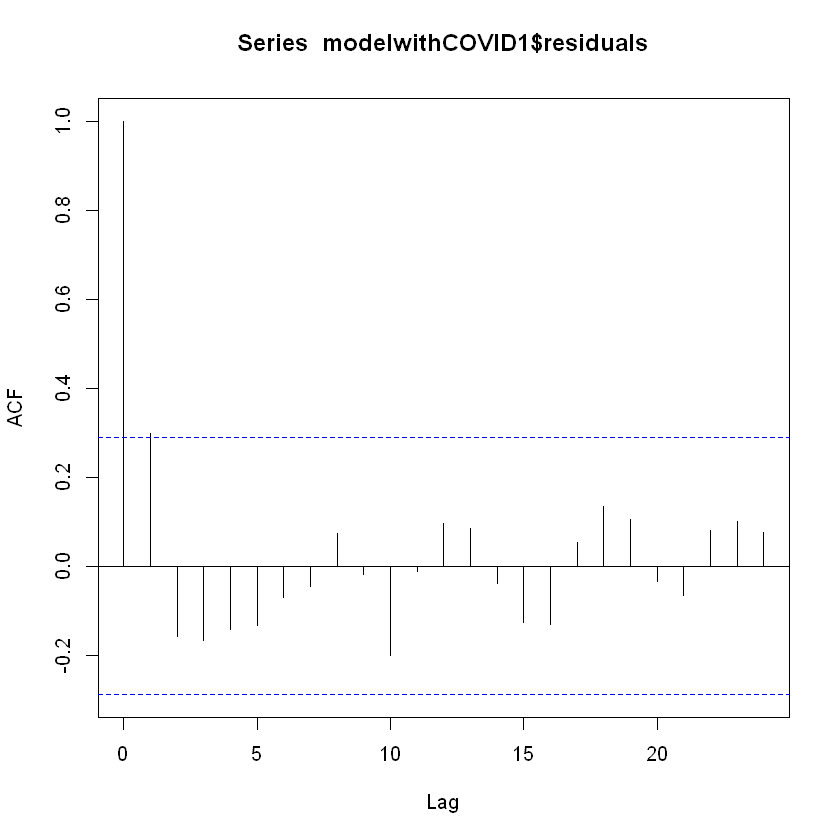

In [21]:
### 각각의 변수의 과거값을 사용한다. 
### 과거값을 포함한 새로운 변수를 추가해본다.
## input X_t-2 ##
data$COVID1 <- c(NA,NA, data$COVID[1:46])
modelwithCOVID1<- lm(priceindex~interest+lnexchange+lnoil+lnKOSPI+COVID1-1, data=data)
summary(modelwithCOVID1)
acf(modelwithCOVID1$residuals, lag.max = 24)
dwtest(modelwithCOVID1)  


Call:
lm(formula = priceindex ~ interest1 + lnexchange + lnoil + lnKOSPI + 
    COVID1 - 1, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75706 -0.22358  0.01602  0.18538  0.83151 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
interest1  -7.285e-01  2.053e-01  -3.548  0.00101 ** 
lnexchange  9.360e+00  3.911e-01  23.935  < 2e-16 ***
lnoil       1.035e+00  3.130e-01   3.306  0.00201 ** 
lnKOSPI     3.943e+00  3.906e-01  10.097 1.46e-12 ***
COVID1      3.610e-05  5.071e-06   7.119 1.28e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3625 on 40 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 6.9e+05 on 5 and 40 DF,  p-value: < 2.2e-16



	Durbin-Watson test

data:  modelwithinterest1
DW = 1.393, p-value = 0.003613
alternative hypothesis: true autocorrelation is greater than 0


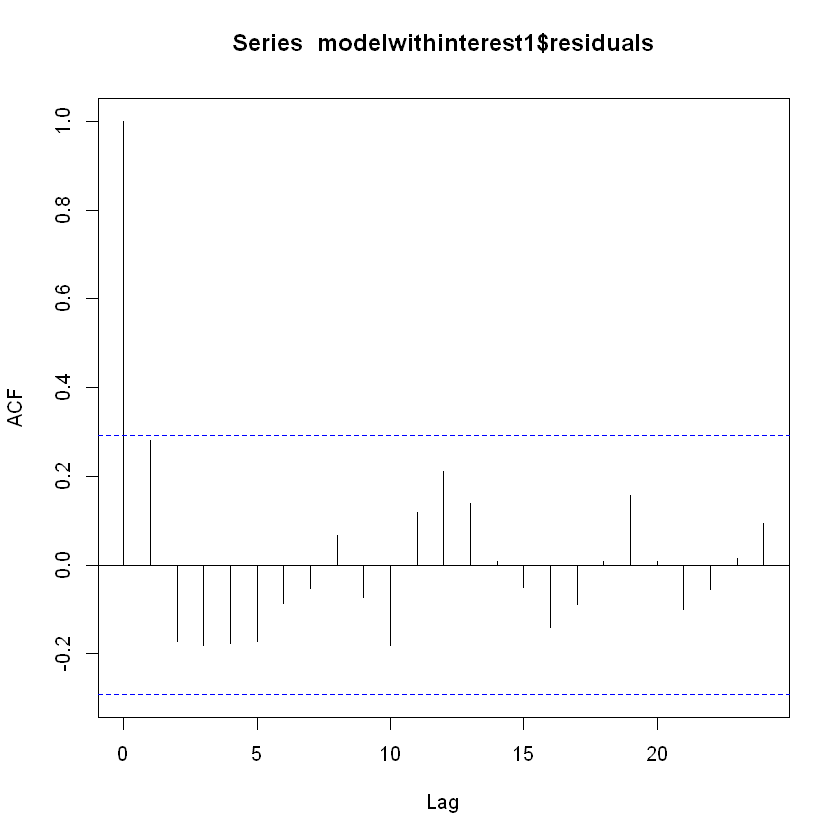

In [22]:
## input X_t-3 ##
data$interest1 <- c(NA,NA,NA, data$interest[1:45])
modelwithinterest1<- lm(priceindex~interest1+lnexchange+lnoil+lnKOSPI+COVID1-1, data=data)
summary(modelwithinterest1)
acf(modelwithinterest1$residuals, lag.max = 24)
dwtest(modelwithinterest1)  


Call:
lm(formula = priceindex ~ interest + lnexchange1 + lnoil + lnKOSPI + 
    COVID1 - 1, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74486 -0.14091 -0.03237  0.12640  0.90474 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
interest    -7.102e-01  1.672e-01  -4.247 0.000121 ***
lnexchange1  9.210e+00  3.508e-01  26.256  < 2e-16 ***
lnoil        1.141e+00  2.657e-01   4.293 0.000105 ***
lnKOSPI      4.014e+00  3.395e-01  11.822 8.66e-15 ***
COVID1       4.105e-05  4.278e-06   9.597 4.84e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3367 on 41 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 8.174e+05 on 5 and 41 DF,  p-value: < 2.2e-16



	Durbin-Watson test

data:  modelwithlnexchange1
DW = 1.3996, p-value = 0.003275
alternative hypothesis: true autocorrelation is greater than 0


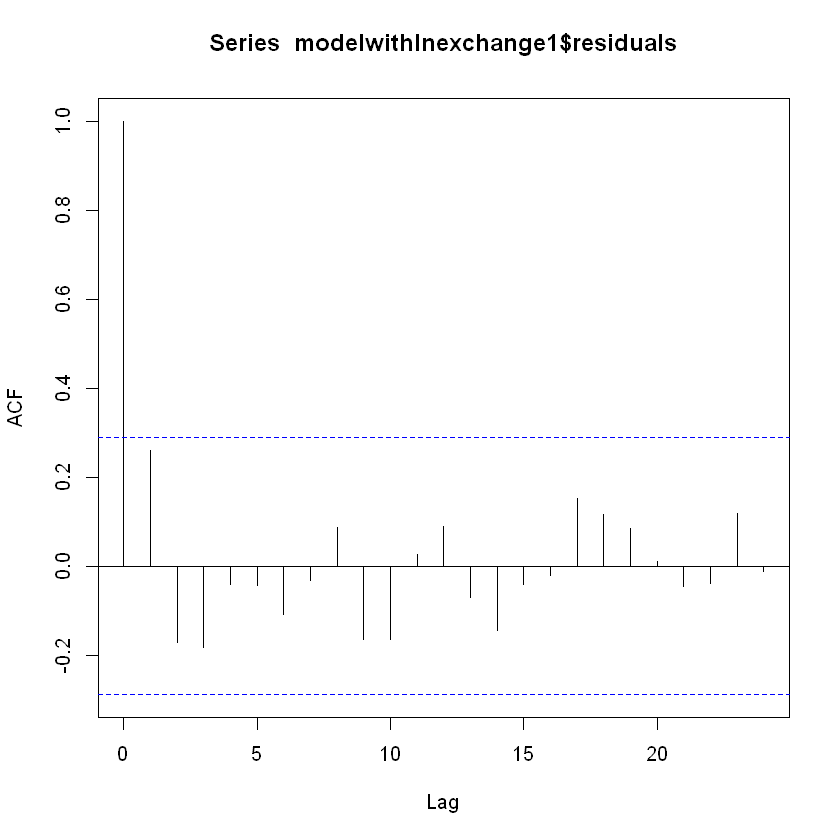

In [23]:
## input X_t-1 ##
data$lnexchange1 <- c(NA, data$lnexchange[1:47])
modelwithlnexchange1<- lm(priceindex~interest+lnexchange1+lnoil+lnKOSPI+COVID1-1, data=data)
summary(modelwithlnexchange1)
acf(modelwithlnexchange1$residuals, lag.max = 24)
dwtest(modelwithlnexchange1)  


Call:
lm(formula = priceindex ~ interest + lnoil + lnKOSPI1 + COVID1 - 
    1, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0446 -0.7627  0.3281  0.8833  2.4086 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
interest -0.6907538  0.6221270  -1.110   0.2732    
lnoil    -0.8016755  1.0619117  -0.755   0.4545    
lnKOSPI1 13.4497247  0.5012573  26.832   <2e-16 ***
COVID1   -0.0000244  0.0000134  -1.820   0.0759 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.257 on 42 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9998 
F-statistic: 7.333e+04 on 4 and 42 DF,  p-value: < 2.2e-16



	Durbin-Watson test

data:  modelwithlnKOSPI1
DW = 0.38363, p-value = 1.751e-14
alternative hypothesis: true autocorrelation is greater than 0


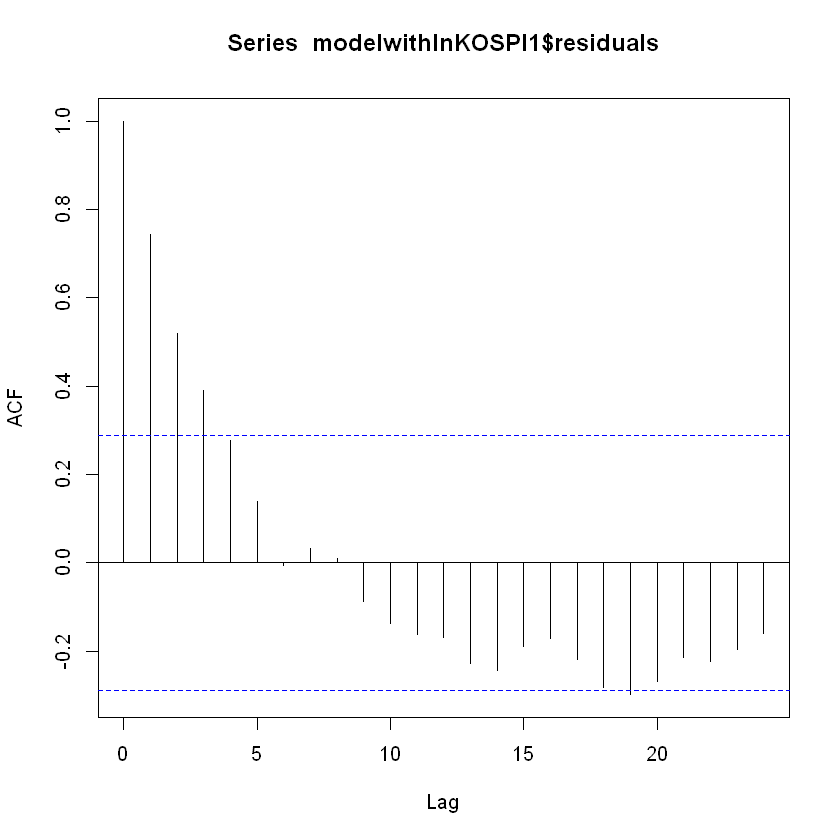

In [24]:
## input X_t-1 ##
data$lnKOSPI1 <- c(NA,NA, data$lnKOSPI[1:46])
modelwithlnKOSPI1<- lm(priceindex~interest+lnoil+lnKOSPI1+COVID1-1, data=data)
summary(modelwithlnKOSPI1)
acf(modelwithlnKOSPI1$residuals, lag.max = 24)
dwtest(modelwithlnKOSPI1)  

📌 3) 변수변환 - 차분(차분은 거의 해결해 준다.)  
  - 변환 후 차분  
  


In [25]:
ynew <- diff(data$priceindex, difference=1)
interest_new <- diff(data$interest, difference = 1)
lngoods_new <- diff(data$lngoods, difference = 1)
lnexchange_new <- diff(data$lnexchange, difference = 1)
lnoil_new <- diff(data$lnoil, difference = 1)
lnKOSPI_new <- diff(data$lnKOSPI, difference = 1)
COVID_new <- diff(data$COVID, difference = 1)

diff_data <- data.frame(ynew, interest_new, lngoods_new, lnexchange_new, lnoil_new, lnKOSPI_new, COVID_new)  


Call:
lm(formula = ynew ~ interest_new + lngoods_new + lnexchange_new + 
    lnoil_new + lnKOSPI_new + COVID_new, data = diff_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68079 -0.17164 -0.00052  0.17654  0.71711 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)  
(Intercept)     1.197e-01  5.150e-02   2.324   0.0253 *
interest_new    9.341e-01  5.041e-01   1.853   0.0713 .
lngoods_new    -8.240e-03  8.849e-02  -0.093   0.9263  
lnexchange_new  4.439e+00  2.906e+00   1.527   0.1346  
lnoil_new       7.964e-01  4.232e-01   1.882   0.0672 .
lnKOSPI_new     1.779e+00  1.030e+00   1.726   0.0921 .
COVID_new      -9.970e-07  3.314e-06  -0.301   0.7651  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3315 on 40 degrees of freedom
Multiple R-squared:  0.291,	Adjusted R-squared:  0.1846 
F-statistic: 2.736 on 6 and 40 DF,  p-value: 0.02537


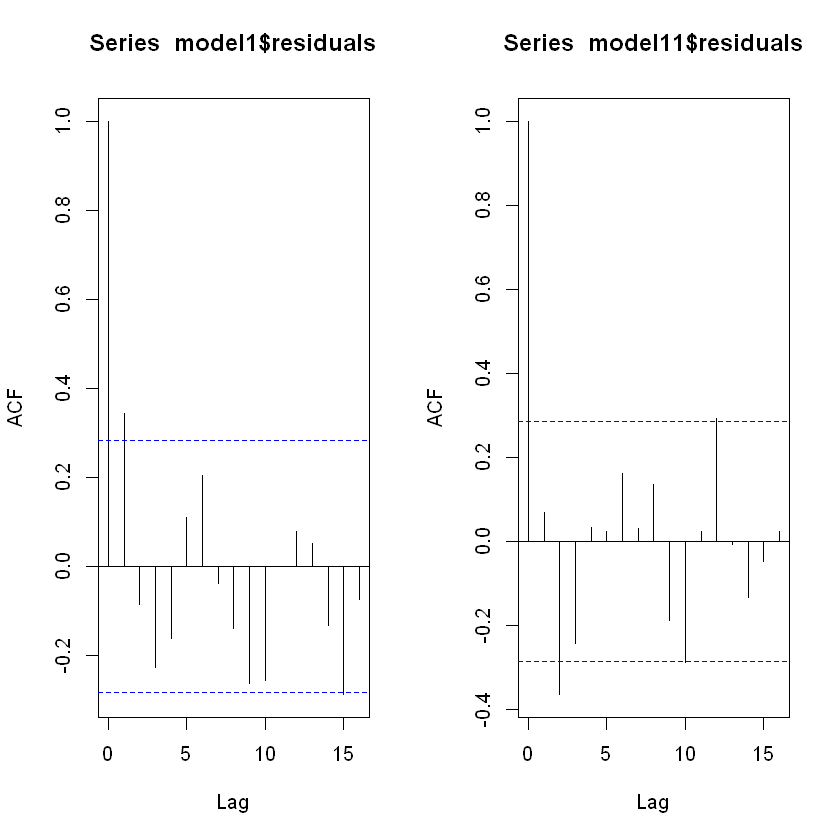

In [26]:
## model 11 : 차분한 모든 변수를 다 넣어본다 ##
model11 <- lm(ynew~interest_new+lngoods_new+lnexchange_new+lnoil_new+lnKOSPI_new+COVID_new, data=diff_data)
summary(model11)
par(mfrow = c(1,2))
acf(model1$residuals)
acf(model11$residuals)  

Start:  AIC=-97.38
ynew ~ interest_new + lngoods_new + lnexchange_new + lnoil_new + 
    lnKOSPI_new + COVID_new

                 Df Sum of Sq    RSS     AIC
- lngoods_new     1   0.00095 4.3955 -99.370
- COVID_new       1   0.00994 4.4045 -99.274
<none>                        4.3946 -97.380
- lnexchange_new  1   0.25627 4.6508 -96.716
- lnKOSPI_new     1   0.32727 4.7218 -96.004
- interest_new    1   0.37725 4.7718 -95.509
- lnoil_new       1   0.38901 4.7836 -95.393

Step:  AIC=-99.37
ynew ~ interest_new + lnexchange_new + lnoil_new + lnKOSPI_new + 
    COVID_new

                 Df Sum of Sq    RSS      AIC
- COVID_new       1   0.00925 4.4048 -101.271
<none>                        4.3955  -99.370
- lnexchange_new  1   0.26580 4.6613  -98.610
- lnKOSPI_new     1   0.32981 4.7253  -97.969
- lnoil_new       1   0.38810 4.7836  -97.393
- interest_new    1   0.41240 4.8079  -97.155

Step:  AIC=-101.27
ynew ~ interest_new + lnexchange_new + lnoil_new + lnKOSPI_new

                 Df 


Call:
lm(formula = ynew ~ interest_new + lnexchange_new + lnoil_new + 
    lnKOSPI_new, data = diff_data)

Coefficients:
   (Intercept)    interest_new  lnexchange_new       lnoil_new     lnKOSPI_new  
        0.1151          0.8684          4.4419          0.8023          1.7817  



Call:
lm(formula = ynew ~ interest_new + lnexchange_new + lnoil_new + 
    lnKOSPI_new, data = diff_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.67323 -0.18256 -0.00794  0.18264  0.72130 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)  
(Intercept)     0.11512    0.04815   2.391   0.0214 *
interest_new    0.86838    0.43164   2.012   0.0507 .
lnexchange_new  4.44191    2.80952   1.581   0.1214  
lnoil_new       0.80233    0.41178   1.948   0.0581 .
lnKOSPI_new     1.78170    1.00557   1.772   0.0837 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3238 on 42 degrees of freedom
Multiple R-squared:  0.2893,	Adjusted R-squared:  0.2216 
F-statistic: 4.274 on 4 and 42 DF,  p-value: 0.005434


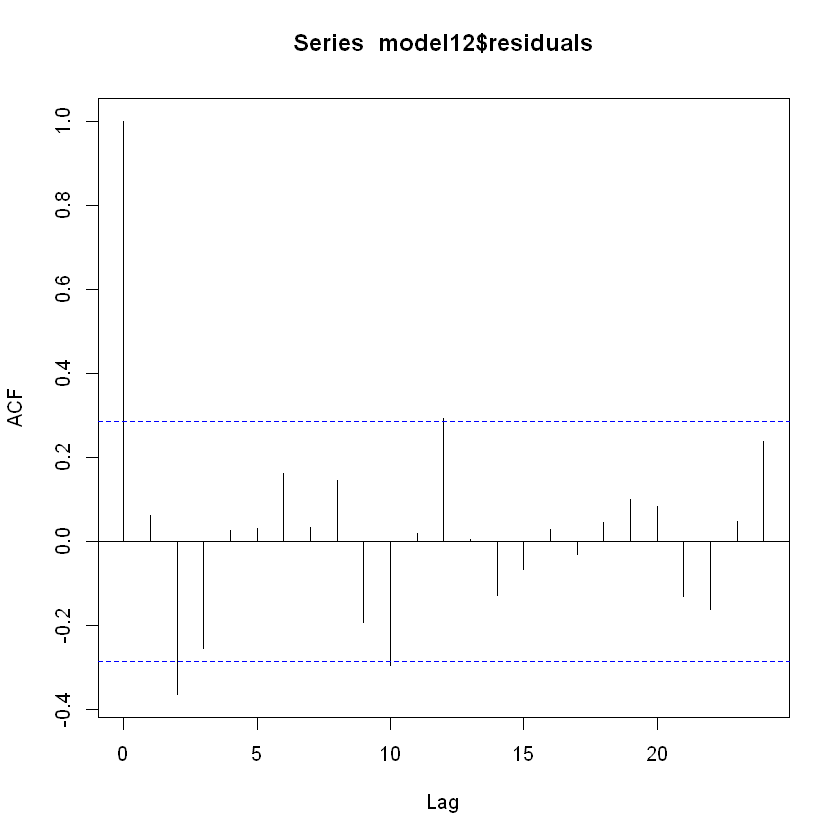

In [27]:
# stepwise 
step(lm(ynew~interest_new+lngoods_new+lnexchange_new+lnoil_new+lnKOSPI_new+COVID_new, data=diff_data),
     scope = list(lower ~ 1, upper = ~interest_new+lngoods_new+lnexchange_new+lnoil_new+lnKOSPI_new+COVID_new), direction = "backward")
## model 12 : stepwise 한 모델
model12 <- lm(formula = ynew ~ interest_new + lnexchange_new + lnoil_new + lnKOSPI_new, data = diff_data)
summary(model12)
# 유의한 변수는 없고 절편만이 유의한 모형을 제시하였다.
par(mfrow = c(1,1))
acf(model12$residuals, lag.max = 24)  


Call:
lm(formula = ynew ~ interest_new + lnexchange_new + lnoil_new + 
    lnKOSPI_new + COVID_new - 1, data = diff_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53349 -0.06351  0.09125  0.30887  0.83241 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)  
interest_new   7.089e-01  4.837e-01   1.465   0.1502  
lnexchange_new 5.290e+00  2.970e+00   1.781   0.0822 .
lnoil_new      8.584e-01  4.383e-01   1.959   0.0568 .
lnKOSPI_new    2.017e+00  1.065e+00   1.894   0.0651 .
COVID_new      1.195e-06  3.269e-06   0.366   0.7166  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3446 on 42 degrees of freedom
Multiple R-squared:  0.2819,	Adjusted R-squared:  0.1965 
F-statistic: 3.298 on 5 and 42 DF,  p-value: 0.01333



	Durbin-Watson test

data:  model13
DW = 1.6155, p-value = 0.08822
alternative hypothesis: true autocorrelation is greater than 0


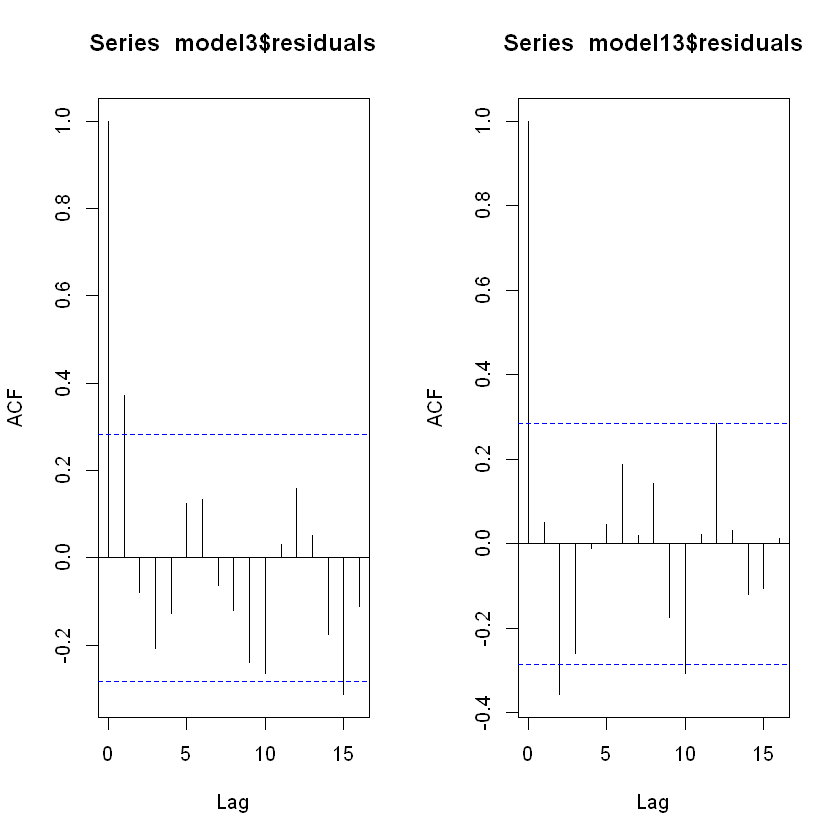

In [28]:
## lngoods 변수는 물가지수와의 상관계수가 0에 가깝고, 거의 모든 모형에서 유의하지 않음을 확인하였으므로 모형에 되도록 넣지 않기로 결정한다.###

## model3 vs. 차분한 모형
model3 <- lm(priceindex~interest+lnexchange+lnoil+lnKOSPI+COVID-1, data=data_ts)
model13 <- lm(ynew ~ interest_new + lnexchange_new + lnoil_new + lnKOSPI_new + COVID_new - 1, data = diff_data)
summary(model13)
par(mfrow = c(1,2))
acf(model3$residuals)
acf(model13$residuals)

dwtest(model13)
## 모형에는 유의하지 않은 변수로 구성되며, 1차자기상관는 없다고 판단된다.
## 차분한 모형에서 모든 변수들이 유의하지 않으므로 차분을 사용하지 않는다.
## 모든 차분 모형은 유의하지 않으므로 차분을 사용하지 않는다.  

***

## 💸 과거값을 사용한 새로운 변수를 만들어 자기상관을 낮춰보도록 한다.  



Call:
lm(formula = testy ~ testinterest + testlnexchange + testlnoil + 
    testlnKOSPI + testCOVID - 1, data = test)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.83906 -0.20287 -0.03575  0.16333  0.86029 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
testinterest   -7.153e-01  1.775e-01  -4.029 0.000244 ***
testlnexchange  8.852e+00  3.512e-01  25.209  < 2e-16 ***
testlnoil       1.193e+00  2.658e-01   4.489 5.93e-05 ***
testlnKOSPI     4.323e+00  3.164e-01  13.660  < 2e-16 ***
testCOVID       3.456e-05  4.706e-06   7.343 6.27e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3241 on 40 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 8.635e+05 on 5 and 40 DF,  p-value: < 2.2e-16



	Durbin-Watson test

data:  modeltest
DW = 1.6409, p-value = 0.03458
alternative hypothesis: true autocorrelation is greater than 0


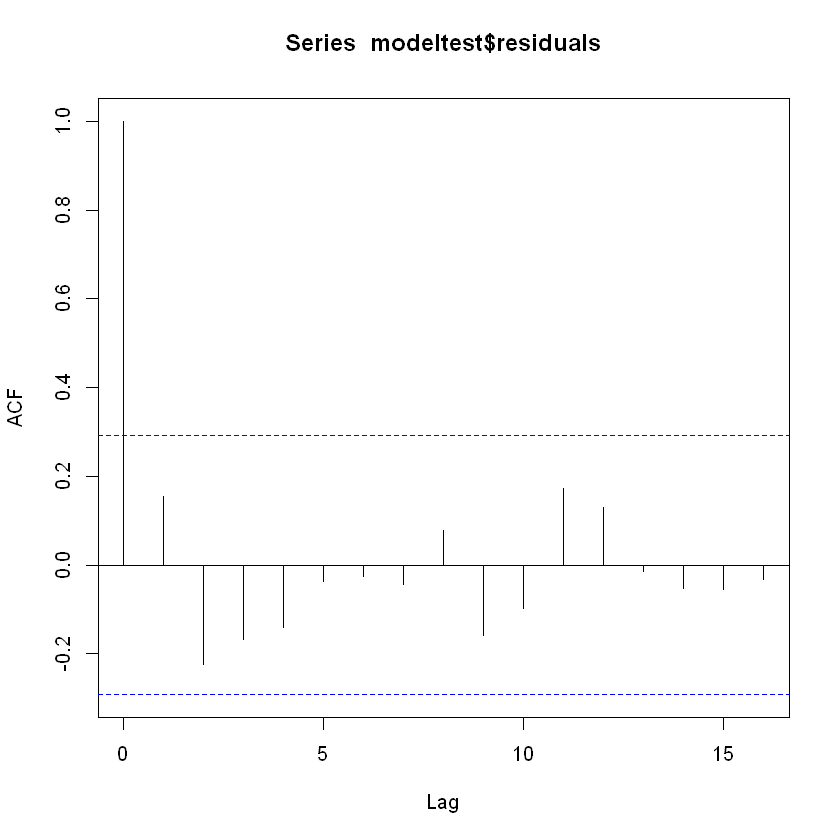

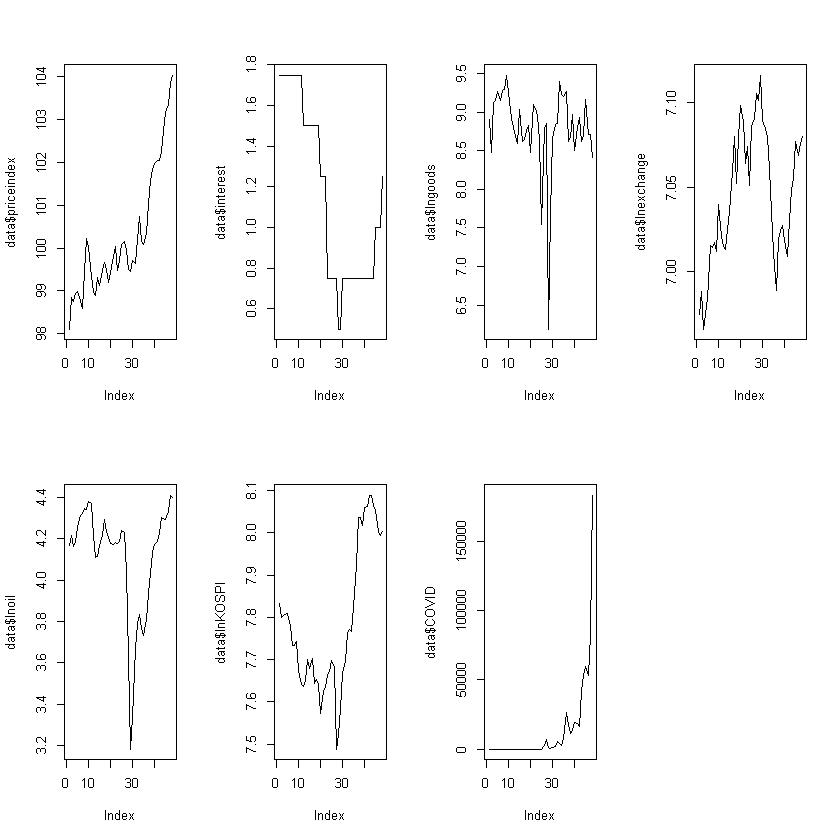

In [29]:
########################################################### TEST 1
par(mfrow = c(1,1))

testy <- data$priceindex
testinterest <- c(NA,NA,NA, data$interest[1:45])
testlngoods <- data$lngoods
testlnexchange <- c(NA, data$lnexchange[1:47])
testlnoil <- c(NA, data$lnoil[1:47])
testlnKOSPI <- data$lnKOSPI            
testCOVID <- c(NA,NA, data$COVID[1:46])
testtime <- data$time

test <- data.frame(testy, testinterest, testlnexchange, testlnoil, testlnKOSPI, testCOVID)
test$COVID_OX <- ifelse(test$testCOVID==0, test$COVID_OX <- 0, test$COVID_OX <- 1)

modeltest <- lm(testy ~ testinterest + testlnexchange + testlnoil + testlnKOSPI + testCOVID-1, data = test)

summary(modeltest)
acf(modeltest$residuals)
dwtest(modeltest)
### dwtest 결과 p-value가 0.03으로 귀무가설을 기각한다.
### 자기상관 문제를 해결하지 못했다.

par(mfrow = c(2,4))
plot(data$priceindex, type = 'l')
plot(data$interest, type = 'l')
plot(data$lngoods, type = 'l')
plot(data$lnexchange, type = 'l')
plot(data$lnoil, type = 'l')
plot(data$lnKOSPI, type = 'l')
plot(data$COVID, type = 'l')  


Call:
lm(formula = testy ~ testinterest + testinterest:(testCOVID) + 
    testlnexchange + testlnoil + testlnKOSPI - 1, data = test)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.83398 -0.17787 -0.02295  0.16057  0.86845 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
testinterest           -7.539e-01  1.687e-01  -4.469 6.31e-05 ***
testlnexchange          8.781e+00  3.344e-01  26.262  < 2e-16 ***
testlnoil               1.208e+00  2.560e-01   4.720 2.88e-05 ***
testlnKOSPI             4.387e+00  3.033e-01  14.462  < 2e-16 ***
testinterest:testCOVID  4.152e-05  5.376e-06   7.723 1.88e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3146 on 40 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 9.162e+05 on 5 and 40 DF,  p-value: < 2.2e-16



	Durbin-Watson test

data:  modeltest
DW = 1.6714, p-value = 0.04305
alternative hypothesis: true autocorrelation is greater than 0


[1] 30.33098

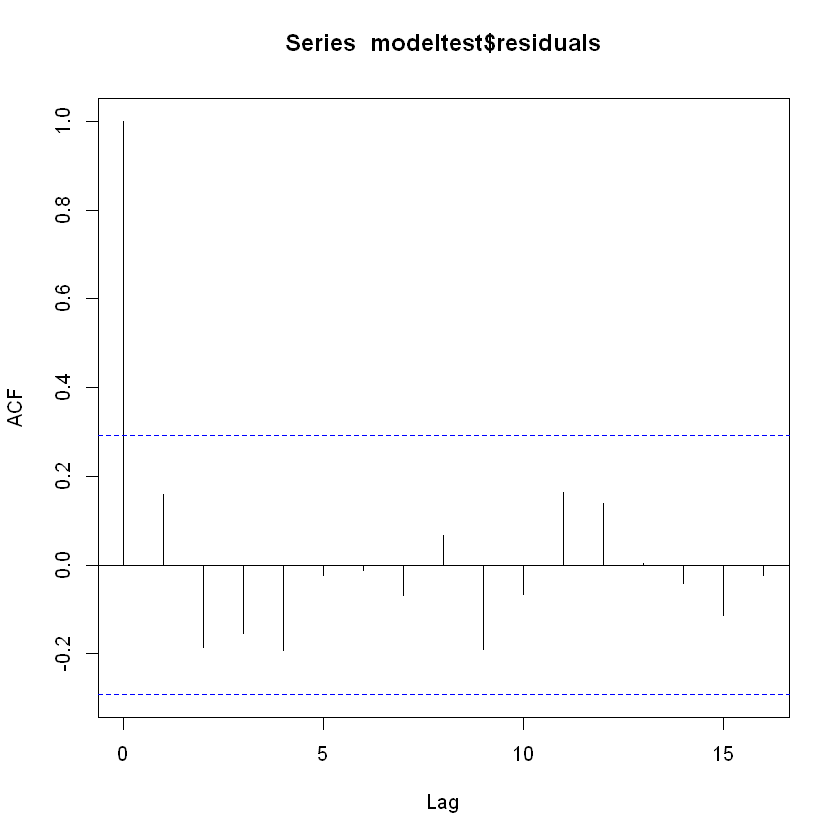

In [30]:
########################################################### TEST 2

testy <- data$priceindex
testinterest <- c(NA,NA,NA, data$interest[1:45])
testlngoods <- c(NA,NA, data$lngoods[1:46])   
testlnexchange <- c(NA, data$lnexchange[1:47])
testlnoil <- c(NA, data$lnoil[1:47])
testlnKOSPI <- data$lnKOSPI            
testCOVID <- c(NA,NA, data$COVID[1:46])
testtime <- data$time


test <- data.frame(testy, testinterest, testlnexchange, testlngoods, testlnKOSPI, testCOVID, testlnoil)
test$COVID_OX <- ifelse(test$testCOVID==0, test$COVID_OX <- 0, test$COVID_OX <- 1)

modeltest <- lm(testy ~  testinterest + testinterest:(testCOVID) + testlnexchange + testlnoil + testlnKOSPI -1, data = test)


summary(modeltest)
acf(modeltest$residuals)
dwtest(modeltest)
### dwtest 결과 p-value가 0.04으로 귀무가설을 기각한다.
### 자기상관 문제를 해결하지 못했다.
AIC(modeltest)  


Call:
lm(formula = testy2 ~ testlnoil2 + testlnKOSPI2 + testCOVID2 + 
    testtime2, data = test2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53347 -0.21994  0.00182  0.15957  0.92205 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.091e+01  3.112e+00  26.004  < 2e-16 ***
testlnoil2   1.056e+00  2.242e-01   4.709 2.84e-05 ***
testlnKOSPI2 1.712e+00  4.016e-01   4.262 0.000116 ***
testCOVID2   3.049e-05  5.582e-06   5.461 2.52e-06 ***
testtime2    5.968e-02  6.557e-03   9.102 2.16e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3227 on 41 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.9548,	Adjusted R-squared:  0.9503 
F-statistic: 216.3 on 4 and 41 DF,  p-value: < 2.2e-16



	Durbin-Watson test

data:  modeltest2
DW = 1.3125, p-value = 0.001187
alternative hypothesis: true autocorrelation is greater than 0


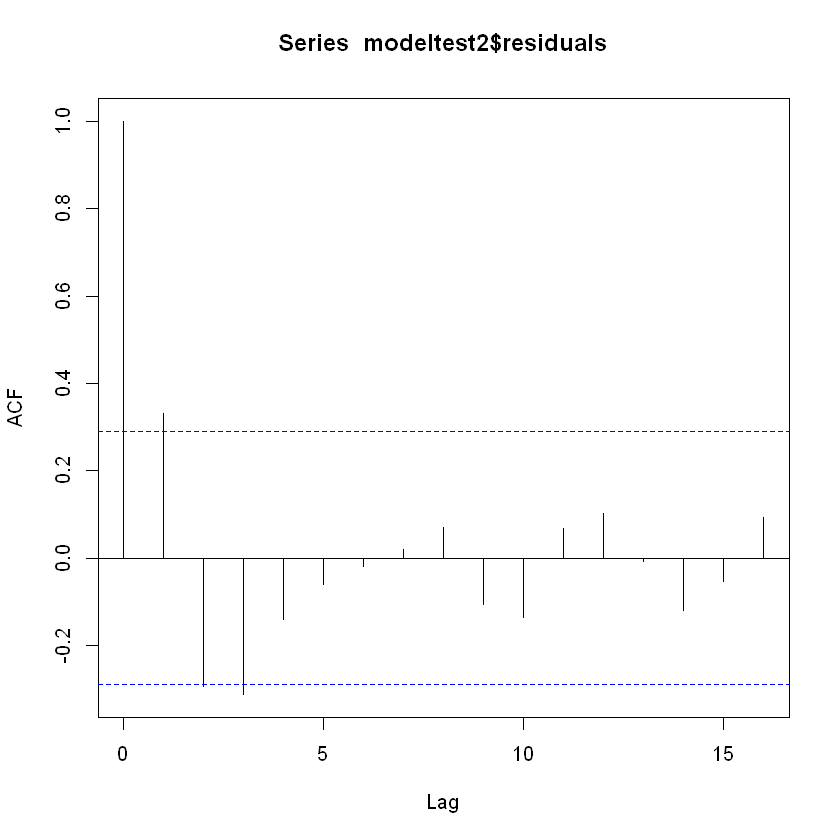

In [31]:
########################################################### TEST 3
testy2 <- data$priceindex
testlnoil2 <- c(NA, data$lnoil[1:47])
testlnKOSPI2 <- data$lnKOSPI
testCOVID2 <- c(NA,NA, data$COVID[1:46]) 
testtime2 <- data$time

test2 <- data.frame(testy2, testlnoil2,testlnKOSPI2,testCOVID2,testtime2)
modeltest2 <- lm(testy2 ~ testlnoil2 + testlnKOSPI2 + testCOVID2 + testtime2, data = test2)


summary(modeltest2)
par(mfrow=c(1,1))
acf(modeltest2$residuals)
dwtest(modeltest2)
### dwtest 결과 p-value가 0.001로 귀무가설을 기각한다.
### 자기상관 문제를 해결하지 못했다.  

## 🏆 최종 모델 생성


Call:
lm(formula = final_target ~ final_interest:(final_COVID) + final_lnexchange:(COVID_OX) + 
    final_lnoil + final_lnexchange + final_lnKOSPI, data = final)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.87142 -0.14990  0.01518  0.17462  0.96495 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -7.058e+01  1.860e+01  -3.796 0.000478 ***
final_lnoil                 1.395e+00  2.652e-01   5.258 4.88e-06 ***
final_lnexchange            1.643e+01  2.133e+00   7.705 1.69e-09 ***
final_lnKOSPI               6.300e+00  5.913e-01  10.656 2.20e-13 ***
final_interest:final_COVID  8.536e-06  2.346e-06   3.639 0.000759 ***
final_lnexchange:COVID_OX   7.268e-02  2.822e-02   2.576 0.013705 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3451 on 41 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9494,	Adjusted R-squared:  0.9432 



	Durbin-Watson test

data:  model_final
DW = 1.8058, p-value = 0.08504
alternative hypothesis: true autocorrelation is greater than 0


[1] 40.94741

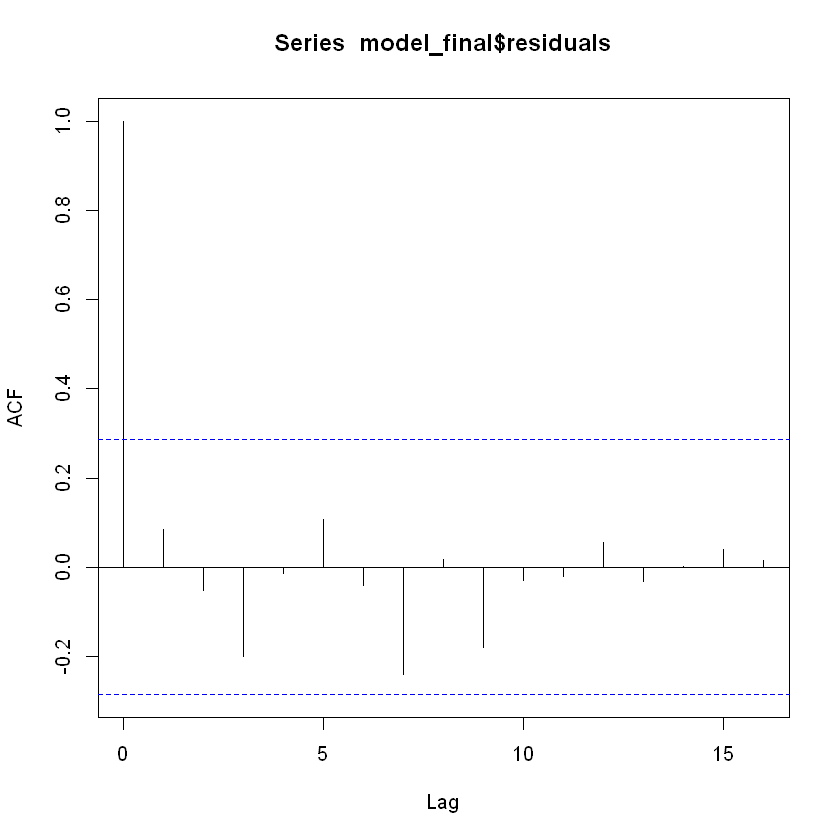

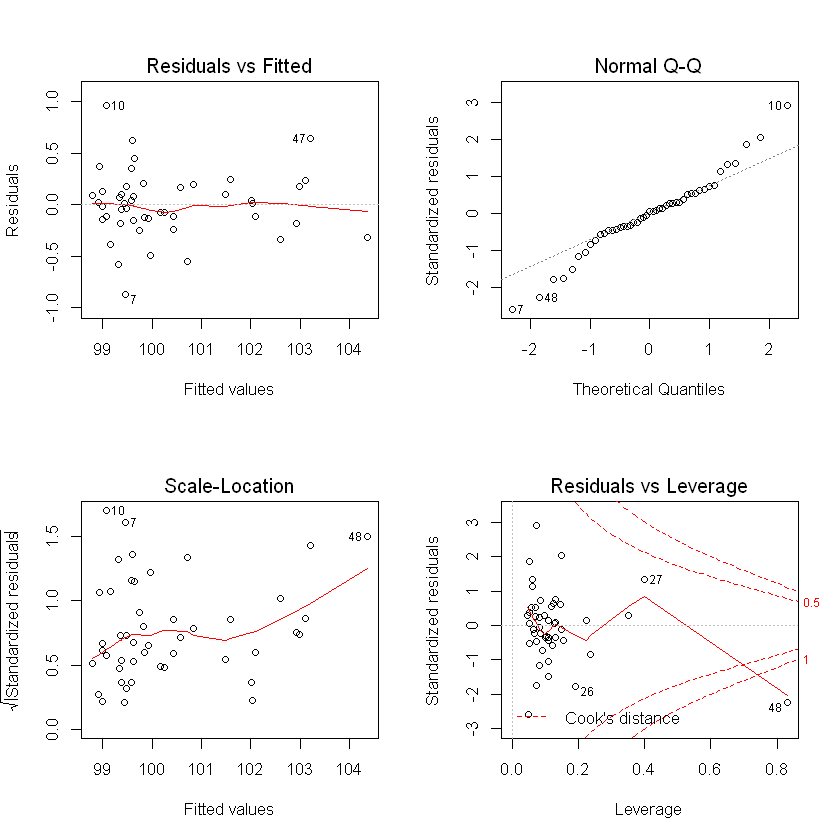

In [32]:
########################################################### FINAL TEST 
final_target <- data$priceindex
final_interest <- c(NA, data$interest[1:47])
final_lngoods <- c(NA,NA,NA, data$lngoods[1:45])       
final_lnexchange <- c(NA, data$lnexchange[1:47])
final_lnoil <- c(NA, data$lnoil[1:47])
final_lnKOSPI <- data$lnKOSPI            
final_COVID <-  data$COVID 
final_time <- data$time


final <- data.frame(final_target, final_interest, final_lnexchange, final_lngoods, final_lnKOSPI, final_COVID, final_lnoil, final_time)

final$COVID_OX <- ifelse(final$final_COVID==0, final$COVID_OX <- 0, final$COVID_OX <- 1)
final$COVID_OX <- c(NA, final$COVID_OX[1:47])

model_final <- lm(final_target ~ final_interest:(final_COVID) + final_lnexchange:(COVID_OX) + final_lnoil + final_lnexchange + final_lnKOSPI, data = final)

summary(model_final)
acf(model_final$residuals)
dwtest(model_final)
### dwtest 결과 p-value가 0.08으로 귀무가설을 기각하지 못한다.
### 자기상관 문제를 해결하였다. 

AIC(model_final)

par(mfrow = c(2,2))
plot(model_final)  

## 💸 종속변수 예측에 미치는 각 독립변수별 설명정도를 시각화하였다.  



,Weights
final_lnoil,6.414000
final_lnexchange,7.867134
final_interest,10.708314
COVID_OX,15.419624
final_COVID,26.318275
final_lnKOSPI,33.272654


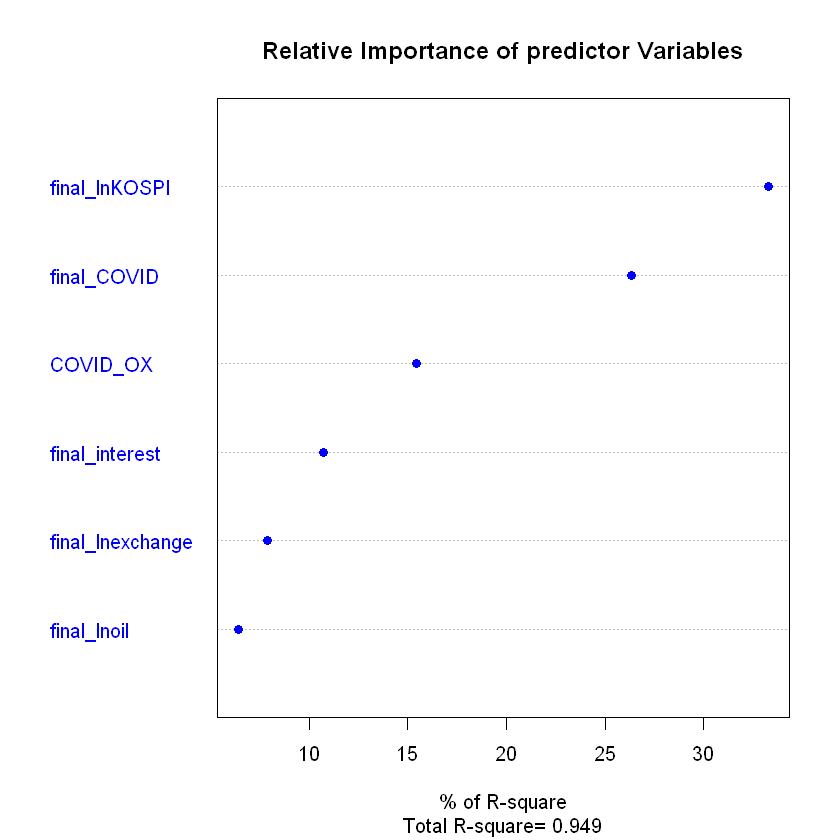

In [33]:
relweights <- function(fit, col){
  R <- cor(fit$model)
  nvar <- ncol(R)
  rxx <- R[2:nvar, 2:nvar]
  rxy <- R[2:nvar, 1]
  svd <- eigen(rxx)
  evec <- svd$vectors
  ev <- svd$values
  delta <- diag(sqrt(ev))
  lambda <- evec %*% delta %*% t(evec)
  lambdasq <- lambda^2
  beta <- solve(lambda) %*% rxy
  rsquare <- colSums(beta^2)
  rawwgt <- lambdasq %*% beta ^ 2
  import <- (rawwgt / rsquare) * 100
  import <- as.data.frame(import)
  row.names(import) <- names(fit$model[2:nvar])
  names(import) <- "Weights"
  import <- import[order(import),1,drop = FALSE]
  dotchart(import$Weights, labels = row.names(import),
           xlab = "% of R-square", pch = 19,
           main = "Relative Importance of predictor Variables",
           sub = paste("Total R-square=", round(rsquare, digits = 3)),
           col = col)
  
  return(import)
}

result = relweights(model_final, 'blue')
result  

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


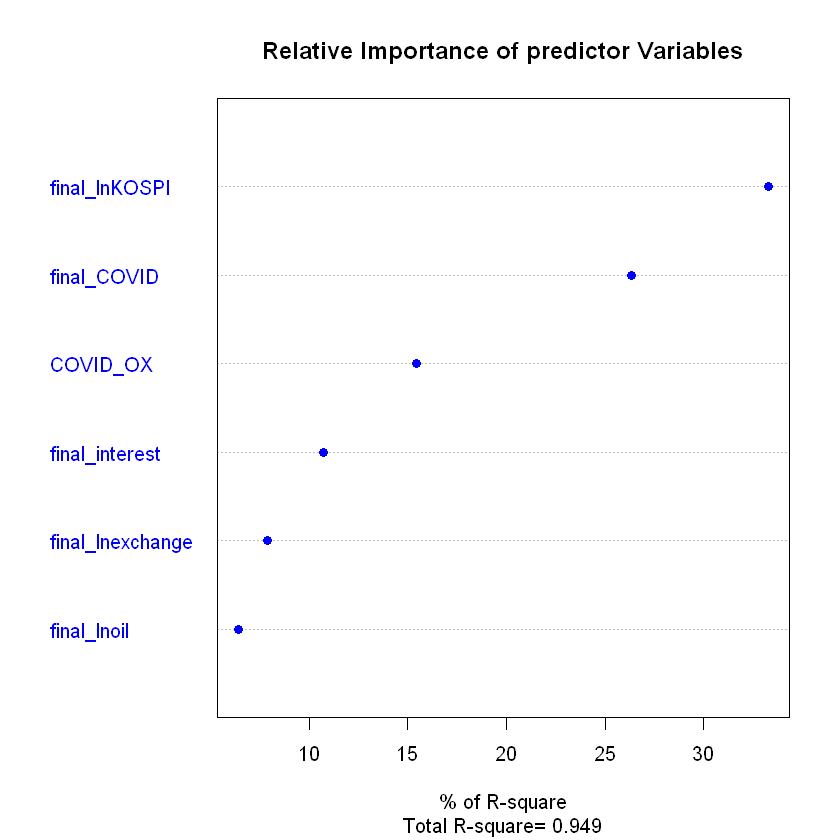

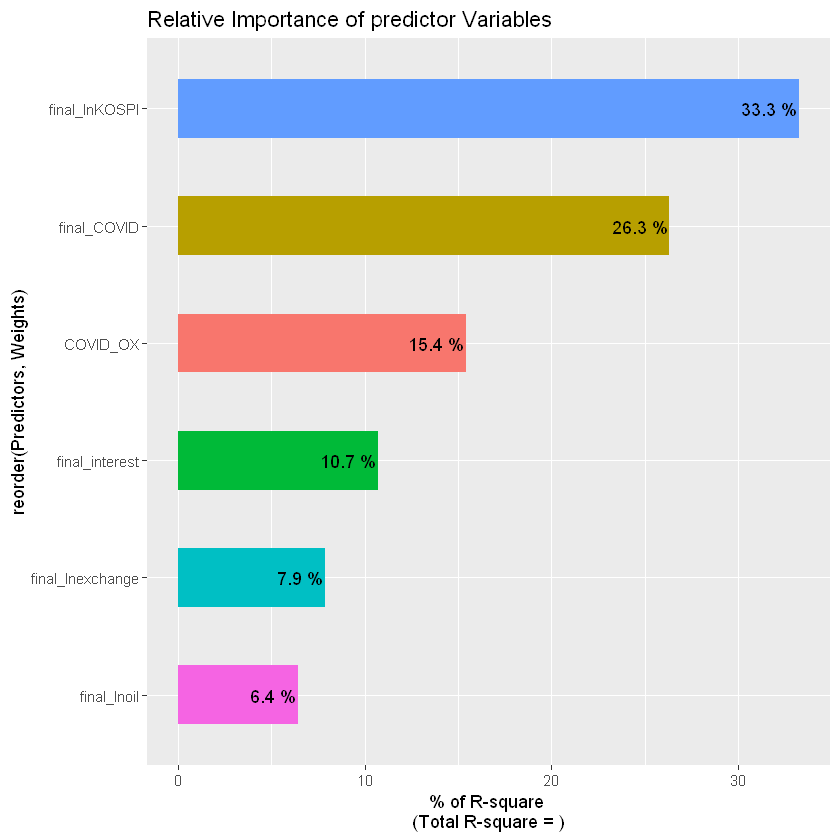

In [34]:
library(ggplot2)
plotRelWeights <- function(fit, col){
  data <- relweights(fit, col)
  data$Predictors <- rownames(data)
  p <- ggplot(data = data, aes(x=reorder(Predictors, Weights), y = Weights, fill=Predictors))+
    geom_bar(stat = 'identity',width = 0.5)+
    ggtitle("Relative Importance of predictor Variables")+
    ylab(paste0("% of R-square \n(Total R-square = ",attr(data, "R-square"),")"))+
    geom_text(aes(y=Weights-0.1, label=paste(round(Weights,1),"%")), hjust=1)+
    guides(fill=FALSE)+
    coord_flip()
  
  p
}

plotRelWeights(model_final, 'blue')  